In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

In [2]:
# Inputs

nside = 64
lmax = 2*nside-1
Nlbin = 10
fsky = 0.7
complexity = 'baseline' # Should be 'baseline', 'medium_complexity' or 'high_complexity'
order = '1bts'
fix = 1
adaptative = True
cov_type = 'Nmt-fg'
kw = ''

if complexity == 'baseline':
    dusttype, synctype = 'b', 'b'
elif complexity == 'medium_complexity':
    dusttype, synctype = 'm', 'm'
elif complexity == 'high_complexity':
    dusttype, synctype == 'h', 'h'

if adaptative:
    kw += '_adaptative'

name = 'moments_%s_%s_%s_o%s%s' % (complexity, fsky, cov_type, order, kw) # Name of the config
path = '../BmodeLike/inputs/%s' % (name)

In [3]:
# Load results

results = np.load('../best_fits/results_d%ss%s_%s_%s_gaussbeam_bandpass_ds_o%s_fix%s%s.npy'
               % (dusttype, synctype, fsky, cov_type, order, fix, kw), allow_pickle=True).item()

In [4]:
# Compute CMB BB spectrum for each simulation

b = nmt.NmtBin.from_lmax_linear(lmax=lmax, nlb=Nlbin, is_Dell=False)
leff = b.get_effective_ells()
Nbins = len(leff)
lmins = [int(b.get_ell_min(i)) for i in range(Nbins)]
lmaxs = [int(b.get_ell_max(i)) for i in range(Nbins)]

r = results['r']
Nsims = r.shape[1]

Cl_lens = b.bin_cell(hp.read_cl('../power_spectra/Cls_LiteBIRD_e2e_r0.fits')[2, :2*nside])[:Nbins]
Cl_tens = b.bin_cell(hp.read_cl('../power_spectra/Cls_Planck2018_tensor_r1.fits')[2, :2*nside])[:Nbins]

Cl_cmb = np.zeros((Nsims, Nbins))
for k in range(Nsims):
    Cl_cmb[k] = Cl_lens + r[:, k] * Cl_tens

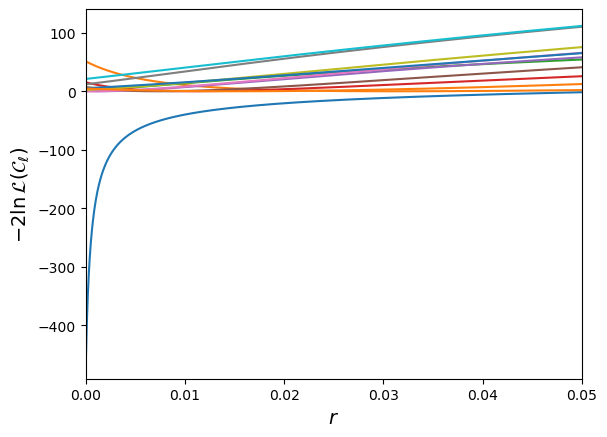

In [5]:
# Gerbino+20 Eq. (49a)

k = 0

def loglike_Cl(r, Cl_hat):
    Cl_th = Cl_lens + r* Cl_tens
    return (2*leff+1) * (Cl_hat / Cl_th - np.log(np.abs(Cl_hat/ Cl_th)) - 1)

N_grid = 1000
r_grid = np.linspace(0, 5e-2, N_grid)

loglike = np.zeros((Nbins, N_grid))
for i in range(N_grid):
    loglike[:, i] = loglike_Cl(r_grid[i], Cl_cmb[k])

# Plot for each multipole

for i in range(Nbins):
    plt.plot(r_grid, loglike[i])
plt.xlim(min(r_grid), max(r_grid))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel(r'$-2 \ln{\mathcal{L}(\mathcal{C}_\ell)}$', fontsize=14)
plt.show()

/tmp/ipykernel_1289727/2058704363.py:6: RuntimeWarning: invalid value encountered in log
  return np.sign(x-1) * np.sqrt(2 * (x-np.log(x)-1))


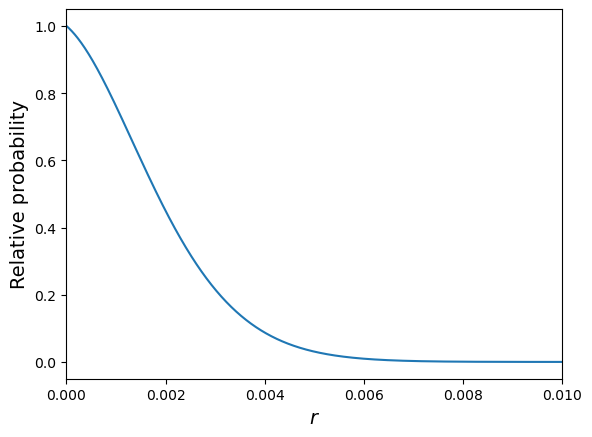

In [6]:
# Gerbino+20 Eq. (51)

k = 0

def g(x):
    return np.sign(x-1) * np.sqrt(2 * (x-np.log(x)-1))

N_grid = 1000
r_grid = np.linspace(0, 1e-2, N_grid)

G = np.zeros((Nbins, N_grid))
for i in range(N_grid):
    Cl_th = Cl_lens + r_grid[i] * Cl_tens
    G[:, i] = g(Cl_cmb[k]/Cl_th) * Cl_lens

cov = np.cov(Cl_cmb.T)
invcov = np.linalg.inv(cov)

chi2 = 0
for i in range(2, Nbins):
    for j in range(2, Nbins):
        chi2 += G[i] * invcov[i,j] * G[j]

L = np.exp(-1/2 * chi2)

plt.plot(r_grid, L/max(L))
plt.xlim(min(r_grid), max(r_grid))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel('Relative probability', fontsize=14)
plt.show()

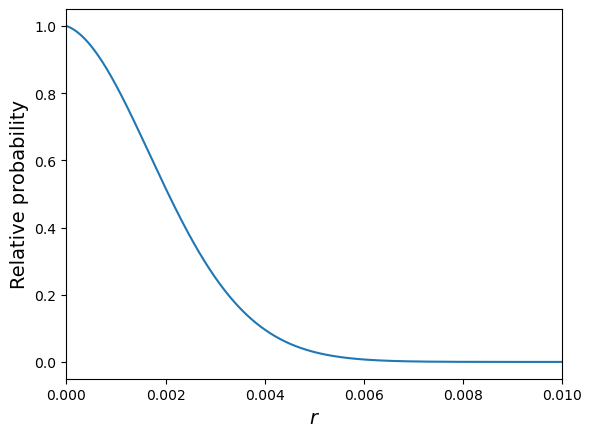

In [7]:
# Offset Hamimeche-Lewis

k = 0
fsky = 59.46942219524857

N_grid = 1000
r_grid = np.linspace(0, 1e-2, N_grid)

def compute_offset(ell, varcl, clref, fsky, N_iter=1):
    Nl = np.sqrt(np.abs(varcl - (2 / (2*ell+1) * clref**2) / fsky))
    for i in range(N_iter):
        Nl = np.sqrt(np.abs(varcl - 2 / (2*ell+1) / fsky * (clref**2 + 2 * Nl * clref)))
    return Nl * np.sqrt((2*ell+1) / 2)

def og(x):
    return np.sign(x) * g(np.abs(x))

offset = compute_offset(leff, np.diag(cov), Cl_lens, fsky)
oCl_cmb = Cl_cmb + offset
oCl_lens = Cl_lens + offset

oG = np.zeros((Nbins, N_grid))
for i in range(N_grid):
    Cl_th = Cl_lens +  r_grid[i] * Cl_tens
    oCl_th = Cl_th + offset
    oG[:, i] = og(oCl_cmb[k]/oCl_th) * oCl_lens

cov = np.cov(Cl_cmb.T)
invcov = np.linalg.inv(cov)

chi2 = np.zeros(N_grid)
for i in range(Nbins):
    for j in range(Nbins):
        chi2 += oG[i] * invcov[i,j] * oG[j]

L = np.exp(-1/2 * chi2)

plt.plot(r_grid, L/max(L))
plt.xlim(min(r_grid), max(r_grid))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel('Relative probability', fontsize=14)
plt.show()

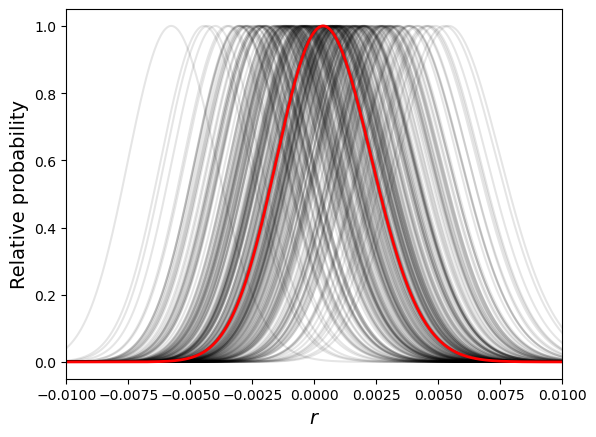

In [29]:
# Final posterior

N_grid = 1000
r_grid = np.linspace(-1e-2, 1e-2, N_grid)

chi2 = np.zeros((Nsims, N_grid))
L = np.zeros((Nsims, N_grid))
for k in range(Nsims):
    oG = np.zeros((Nbins, N_grid))
    for i in range(N_grid):
        Cl_th = Cl_lens +  r_grid[i] * Cl_tens
        oCl_th = Cl_th + offset
        oG[:, i] = og(oCl_cmb[k]/oCl_th) * oCl_lens

    for i in range(Nbins):
        for j in range(Nbins):
            chi2[k] += oG[i] * invcov[i,j] * oG[j]

    L[k] = np.exp(-1/2 * chi2[k])
    L[k] /= max(L[k])
    plt.plot(r_grid, L[k], color='black', alpha=0.1)

chi2_final = np.mean(chi2, axis=0)

posterior = np.exp(-1/2 * chi2_final)
posterior /= max(posterior)

plt.plot(r_grid, posterior, linewidth=2, color='red')
plt.xlim(min(r_grid), max(r_grid))
plt.xlabel(r'$r$', fontsize=14)
plt.ylabel('Relative probability', fontsize=14)
plt.show()

In [31]:
first_moment = np.sum(r_grid * posterior) / np.sum(posterior)
second_moment = np.sum(r_grid**2 * posterior) / np.sum(posterior)

bias = r_grid[np.argmax(posterior)]
sigma_r = np.sqrt(second_moment - first_moment**2)

print('bias =', bias)
print('sigma_r =', sigma_r)

bias = 0.00035035035035035043
sigma_r = 0.0019139297158948614
